# Python и статистика

Проект №8 - А/А-тестирование.

# Введение

## Постановка задачи

Проведено А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества **FPR** (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

1. Запустите A/A-тест
2. Посчитайте **FPR** на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что **FPR** > **альфа**! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

Как найти поломку? Вам доступна версия мобильного приложения (МП) каждого пользователя. Эту полезную информацию можно использовать для исследования проблемы:

* Посчитайте конверсию (коэффициент покупок), группируя по варианту и версии МП. Возможно уже станет ясно где именно причины поломки
* Посчитайте pvalue для каждой версии МП
* Найдите версии, где **p-value** < 0.05
* Исключите версию с **p-value** < 0.05 из основного датафрейма
* Повторно запустите расчет **FPR** через A/A. Теперь **FPR** < **альфа**
* Вы нашли поломку

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
# import pingouin as pg

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [3]:
df = pd.read_csv('./data/hw_aa.csv' , sep = ';', index_col = 0)

### Описание данных

- `experimentVariant` – вариант эксперимента
- `version` – версия приложения
- `purchase` – факт покупки

In [4]:
df

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [5]:
df.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [6]:
df.shape[0]

127018

In [7]:
df.uid.nunique()

127018

In [8]:
purchases = \
    df \
    .groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase': 'sum'}) \
    .rename(columns = {'purchase': 'purchases'})

events = \
    df \
    .groupby(['experimentVariant', 'version'], as_index = False) \
    .agg({'purchase': 'count'}) \
    .rename(columns = {'purchase': 'events'})

In [9]:
grouping = \
    purchases \
    .merge(events, on = ['experimentVariant', 'version'], how = 'right')

# Add conversion-to-purchases metrics column.
grouping['CTP'] = grouping['purchases'] / grouping['events']

In [10]:
grouping

,experimentVariant,version,purchases,events,CTP
0,0,v2.8.0,41,41283,0.000993
1,0,v2.9.0,890,11921,0.074658
2,0,v3.7.4.0,252,4204,0.059943
3,0,v3.8.0.0,328,5694,0.057604
4,1,v2.8.0,1895,41552,0.045606
5,1,v2.9.0,858,12033,0.071304
6,1,v3.7.4.0,266,4221,0.063018
7,1,v3.8.0.0,384,6110,0.062848


То же, но уже в виде сводных таблиц:

In [11]:
grouping.pivot(index = 'version',
               columns = 'experimentVariant',
               values = 'events')

experimentVariant,0,1
version,,
v2.8.0,41283,41552
v2.9.0,11921,12033
v3.7.4.0,4204,4221
v3.8.0.0,5694,6110


In [12]:
grouping.pivot(index = 'version',
               columns = 'experimentVariant',
               values = 'purchases')

experimentVariant,0,1
version,,
v2.8.0,41,1895
v2.9.0,890,858
v3.7.4.0,252,266
v3.8.0.0,328,384


In [13]:
grouping.pivot(index = 'version',
               columns = 'experimentVariant',
               values = 'CTP')

experimentVariant,0,1
version,,
v2.8.0,0.000993,0.045606
v2.9.0,0.074658,0.071304
v3.7.4.0,0.059943,0.063018
v3.8.0.0,0.057604,0.062848


Как видим, если сравнивать значения для двух экспериментов,то количество событий (events), количество покупок (purchases) и, соответственно, CTP близки по значениям для всех версий приложения, кроме v2.8.0, где у эксперимента 0 необычно малое количество покупок (41).

## A/A-тест

In [14]:
sample_1 = df[df['experimentVariant'] == 0]
sample_2 = df[df['experimentVariant'] == 1]

In [15]:
print(sample_1.shape[0])
print(sample_2.shape[0])

63102
63916


  0%|          | 0/1000 [00:00<?, ?it/s]

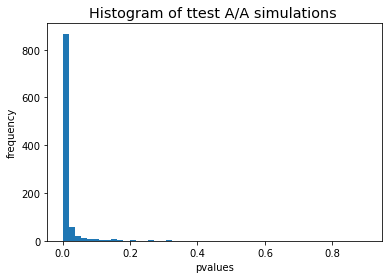

0.94

In [16]:
n_s = 1000 # размер подвыборки
simulations = 1000 # количество симуляций
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = sample_1['purchase'].sample(n_s, replace = False).values
    s2 = sample_2['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) < 0.05) / simulations

Если исключить из рассмотрения v2.8.0, то получим:

In [17]:
sample_1_v2 = sample_1.query("version != 'v2.8.0'")
sample_2_v2 = sample_2.query("version != 'v2.8.0'")

  0%|          | 0/1000 [00:00<?, ?it/s]

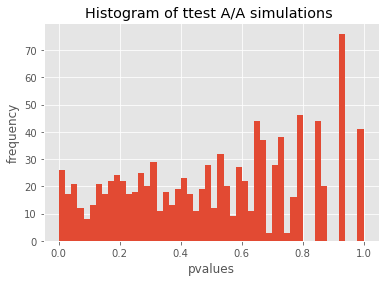

0.049

In [18]:
res2 = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = sample_1_v2['purchase'].sample(n_s, replace = False).values
    s2 = sample_2_v2['purchase'].sample(n_s, replace = False).values
    res2.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res2, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res2) < 0.05) / simulations

Получили долю сравнений, где были обнаружены какие-то различия (со значением p-value менее 0.05), около 5 %. Можно считать, что тест сошёлся.

# Вывод

Некорректное разбиение по группам обнаружено для версии v2.8.0: при сравнении значений для двух экспериментов, количество событий (events), количество покупок (purchases) и, соответственно, **CTP** близки по значениям для всех версий приложения, кроме v2.8.0 -- в эксперименте 0 количество покупок 41, тогда как в эксперименте 1 -- 1895, при том что значения общего количества событий близки.

При исключении данных для версии v2.8.0 A/A-тест сошёлся, и разделение по группам корректно.